In [2]:
import pandas as pd
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from unidecode import unidecode
import unicodedata
import string
import re

In [3]:
movies = pd.read_csv("data/movies_merged.csv")
movies.head(2)

,genres,keywords,overview,popularity,release_date,tagline,title,vote_average,vote_count,cast,crew
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di...",150.437577,10-12-2009,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha...",139.082615,19-05-2007,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [4]:
unique_genres = list()
def str_to_obj(s, key, update_genres=False):
    list_of_dictionaries = literal_eval(s)
    
    key_items = list()
    for item in list_of_dictionaries:
        key_items.append(item[key].lower())
    
    if update_genres:
        unique_genres.extend(key_items)
    return " ".join(key_items)

def get_director(s):
    list_of_dictionaries = literal_eval(s)

    for item in list_of_dictionaries:
        if item["job"] == "Director":
            return item["name"].replace(' ', '_').lower()
        
def get_cast(s):
    list_of_dictionaries =literal_eval(s)
    key_items = list()
    for item in list_of_dictionaries:
        name = item["name"].lower()
        name = name.replace(' ', '_')
        name.strip()
        key_items.append(name)
    return " ".join(key_items)

def convert_to_unicode(df):
    for col in df.columns:
        if df[col].dtype == "int64" or df[col].dtype == "float64":
            continue
        df[col] = df[col].apply(lambda text: unidecode(unicodedata.normalize('NFKD', text)))

def remove_punctuation(s):
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    processed_string = s.translate(translator)
    return re.sub(r"\s+", ' ', processed_string.lower())

In [5]:
convert_to_unicode(movies)

movies.keywords = movies.keywords.apply(lambda x:str_to_obj(x, "name"))
movies.genres = movies.genres.apply(lambda x:str_to_obj(x, "name", True))

movies.crew = movies.crew.apply(get_director)
movies.rename(columns={'crew': 'director'}, inplace=True)

movies.cast = movies.cast.apply(get_cast)

In [6]:
unique_genres = set(sorted(unique_genres))
unique_genres

{'action',
 'adventure',
 'animation',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'foreign',
 'history',
 'horror',
 'music',
 'mystery',
 'romance',
 'science fiction',
 'thriller',
 'tv movie',
 'war',
 'western'}

In [7]:
movies.overview = movies.overview.apply(remove_punctuation)
movies.tagline = movies.tagline.apply(remove_punctuation)
title_processed = movies.title.apply(remove_punctuation)
movies.keywords = movies.keywords.apply(remove_punctuation)

In [8]:
movies["all_keywords"] = movies["keywords"] + ' ' + movies["overview"] + ' ' + movies["tagline"] + ' ' + title_processed

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        4807 non-null   object 
 1   keywords      4807 non-null   object 
 2   overview      4807 non-null   object 
 3   popularity    4807 non-null   float64
 4   release_date  4807 non-null   object 
 5   tagline       4807 non-null   object 
 6   title         4807 non-null   object 
 7   vote_average  4807 non-null   float64
 8   vote_count    4807 non-null   int64  
 9   cast          4807 non-null   object 
 10  director      4778 non-null   object 
 11  all_keywords  4807 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 450.8+ KB


In [10]:
ps = PorterStemmer()
def stem(text):
    # if not isinstance(text, str):
    #     return str(text)

    stemmed_tokens = list()
    for word in text.split():
        if re.match(r'^-?\d+(?:\.\d+)?$', word):
            stemmed_tokens.append(word)
        else:
            stemmed_tokens.append(ps.stem(word))
    return ' '.join(stemmed_tokens)
    
movies["all_keywords"] = movies["all_keywords"].apply(stem)

In [11]:
movies.fillna(' ', inplace=True)
movies.to_csv("data/movies_processed.csv", index=False)

Text(0, 0.5, 'Movie Title')

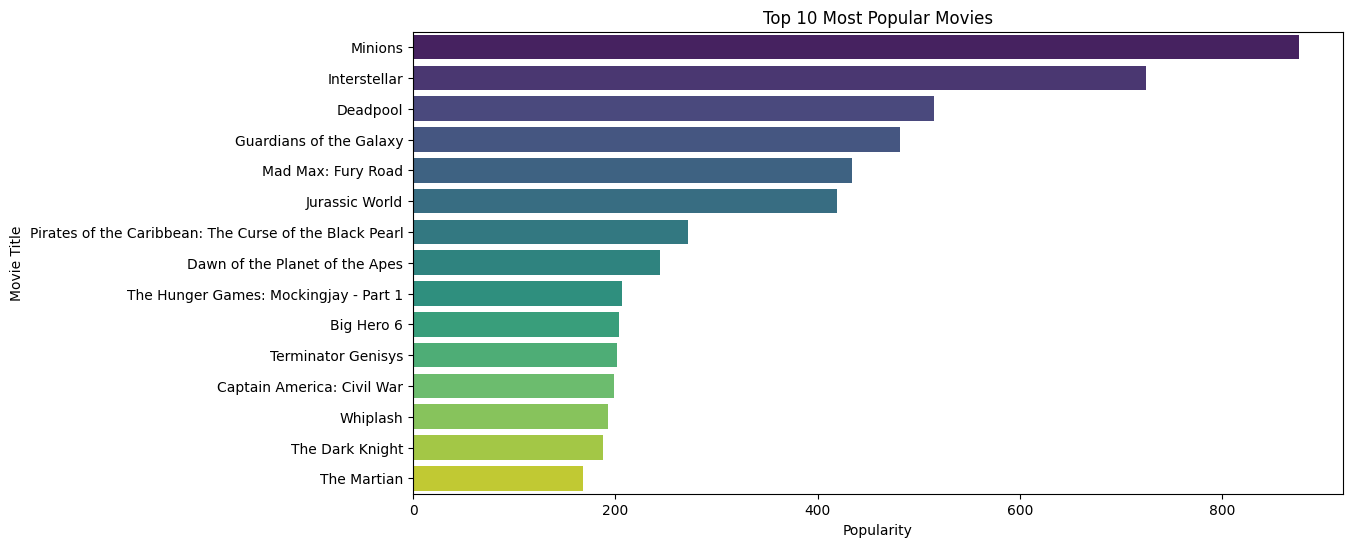

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
top_movies = movies.sort_values(by='popularity', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='popularity', y='title', data=top_movies, palette='viridis')
plt.title('Top 10 Most Popular Movies')
plt.xlabel('Popularity')
plt.ylabel('Movie Title')